# Model Explanation using SHAP

### Common Questions:
1. Why does the model predict what it predicts?
2. How much does each feature contribute to the difference between the final prediction and the average prediction?

In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import xgboost
import shap
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import pickle

# print the JS visualization code to the notebook
shap.initjs()

In [4]:
# Load dataset

# with open('../data/price_data.pickle', 'wb') as f:
#     pickle.dump(price_data, f)

with open('../data/final_dataset.pickle', 'rb') as f:
    final_dataset = pickle.load(f)

In [5]:
def encode_cats(categoricals, numericals, df):
    """
    Takes in a list of categorical columns and a list of numerical columns and returns the dataframe with encoded variables
    """
    ohe = OneHotEncoder(sparse=False, drop='first')
    cat_matrix = ohe.fit_transform(df.loc[:, categoricals])
    X_ohe = pd.DataFrame(cat_matrix,
                         columns=ohe.get_feature_names(categoricals), #create meaningful column names
                         index=df.index) #keep the same index values
    
    return pd.concat([df.loc[:, numericals], X_ohe], axis=1)

In [6]:
# Encode categorical variables
categoricals = list(final_dataset.select_dtypes('object').columns)
numericals = list(final_dataset.select_dtypes(['int64', 'float64', 'int32', 'float32']).columns)
final_dataset = encode_cats(categoricals, numericals, final_dataset)

In [7]:
X = final_dataset.loc[:, "bearish":]
y = final_dataset['direction'].values

In [8]:
# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

In [9]:
# Train the model
params = {
    "eta": 0.01,
    "objective": "multi:softprob",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": ["merror", "mlogloss"],
    "num_class": 3,
    "seed": 42
}
model = xgboost.train(params, dtrain = d_train, num_boost_round = 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

[0]	test-merror:0.47739	test-mlogloss:1.09493
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
[100]	test-merror:0.47236	test-mlogloss:0.88125
[200]	test-merror:0.46734	test-mlogloss:0.80808
[300]	test-merror:0.46231	test-mlogloss:0.77759
Stopping. Best iteration:
[367]	test-merror:0.46734	test-mlogloss:0.77253



In [ ]:
# Classic feature distributions
# Sometimes feature importance calculations can calculate eachother
# Re-iterates the importance of using SHAP for model interpretation

In [ ]:
# xgboost.plot_importance(model)
# pl.title("xgboost.plot_importance(model)")
# pl.show()

In [ ]:
# xgboost.plot_importance(model, importance_type="cover")
# pl.title('xgboost.plot_importance(model, importance_type="cover")')
# pl.show()

In [10]:
# Explain Predictions
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [ ]:
# Visualize a single prediction
# shap.force_plot(explainer.expected_value[1], shap_values[0])

In [ ]:
# Visualize many predictions
# shap.force_plot(explainer.expected_value[1], shap_values[1])

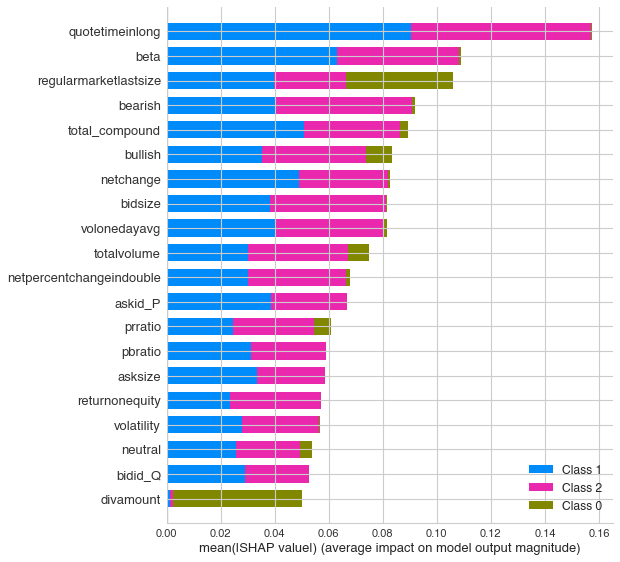

In [11]:
# Bar chart of mean importance
# This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.
shap.summary_plot(shap_values, X, plot_type="bar")

In [ ]:
# SHAP Summary Plot

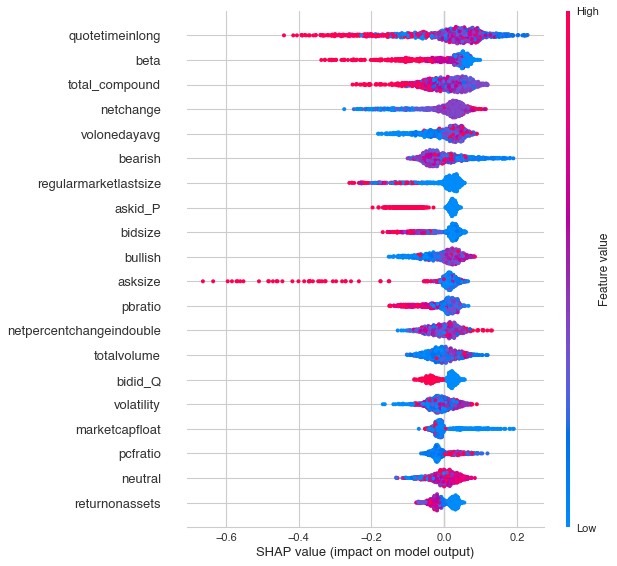

In [28]:
shap.summary_plot(shap_values[1], X)

In [ ]:
# SHAP Dependence Plot

# SHAP dependence plots show the effect of a single feature across the whole dataset.
# They plot a feature’s value vs. the SHAP value of that feature across many samples.
# SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects
# present in the features, and are only defined in regions of the input space supported by data.
# The vertical dispersion of SHAP values at a single feature value is driven by interaction effects,
# and another feature is chosen for coloring to highlight possible interactions.

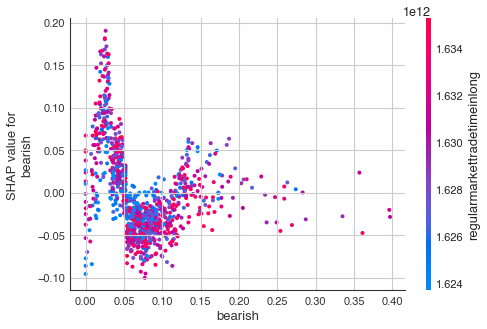

In [36]:
shap.dependence_plot('bearish', shap_values[1], X)

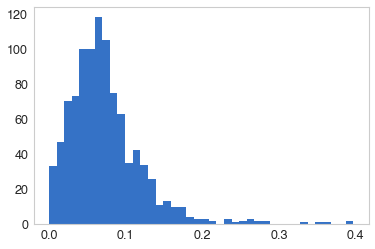

In [25]:
final_dataset['bearish'].hist(bins=40)
plt.grid(b=None)
plt.show;

In [ ]:
# Simple supervised clustering
# Clustering people by their shap_values leads to groups relevent
# to the prediction task at hand (their earning potential in this case)

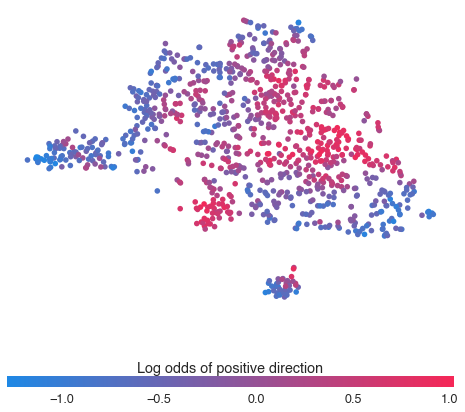

In [48]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.colors import LinearSegmentedColormap

shap_pca50 = PCA(n_components=16).fit_transform(shap_values[1])
shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(shap_values[1])

cdict1 = {
    'red': ((0.0, 0.11764705882352941, 0.11764705882352941),
            (1.0, 0.9607843137254902, 0.9607843137254902)),

    'green': ((0.0, 0.5333333333333333, 0.5333333333333333),
              (1.0, 0.15294117647058825, 0.15294117647058825)),

    'blue': ((0.0, 0.8980392156862745, 0.8980392156862745),
             (1.0, 0.3411764705882353, 0.3411764705882353)),

    'alpha': ((0.0, 1, 1),
              (0.5, 1, 1),
              (1.0, 1, 1))
}  # #1E88E5 -> #ff0052
red_blue_solid = LinearSegmentedColormap('RedBlue', cdict1)

f = pl.figure(figsize=(8,8))
pl.scatter(shap_embedded[:,0],
           shap_embedded[:,1],
           c=shap_values[1].sum(1).astype(np.float64),
           linewidth=0, alpha=1., cmap=red_blue_solid)
cb = pl.colorbar(label="Log odds of positive direction", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()

In [ ]:
# for feature in ["quotetimeinlong", "bullish", "bearish", "total_compound"]:
#     f = pl.figure(figsize=(5,5))
#     pl.scatter(shap_embedded[:,0],
#                shap_embedded[:,1],
#                c=X[feature].values[:1000].astype(np.float64),
#                linewidth=0, alpha=1., cmap=red_blue_solid)
#     cb = pl.colorbar(label=feature, aspect=40, orientation="horizontal")
#     cb.set_alpha(1)
#     cb.draw_all()
#     cb.outline.set_linewidth(0)
#     cb.ax.tick_params('x', length=0)
#     cb.ax.xaxis.set_label_position('top')
#     pl.gca().axis("off")
#     pl.show()